In [4]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
import pickle
from tensorflow.keras.applications import Xception

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define tumor types
tumor_types = ['1no_tumor', 'glioma', 'meningioma', 'pituitary']

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Num GPUs Available:  1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define directories
train_dir = '/content/drive/MyDrive/CNN_MODEL1/Dataset_41/Training'
val_dir = '/content/drive/MyDrive/CNN_MODEL1/Dataset_41/Validation'

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',  # Change to categorical
    classes=tumor_types  # Adjust classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',  # Change to categorical
    classes=tumor_types  # Adjust classes
)

Found 8582 images belonging to 4 classes.
Found 829 images belonging to 4 classes.


In [6]:
# Define the model

base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='max')

# Define your model
model = Sequential([
    base_model_xception,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming you have train_generator and val_generator)
with tf.device('/GPU:0'):
 history = model.fit(train_generator, epochs=16, validation_data=val_generator, shuffle=False)

print(f"\nTraining Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")

Epoch 1/16
68/68 [==============================] - 1154s 17s/step - loss: 5.1490 - accuracy: 0.8991 - val_loss: 2.8579 - val_accuracy: 0.7093
Epoch 2/16
68/68 [==============================] - 47s 685ms/step - loss: 1.6521 - accuracy: 0.9354 - val_loss: 18480.8633 - val_accuracy: 0.3124
Epoch 3/16
68/68 [==============================] - 48s 705ms/step - loss: 0.7583 - accuracy: 0.9547 - val_loss: 1.4444 - val_accuracy: 0.6490
Epoch 4/16
68/68 [==============================] - 47s 691ms/step - loss: 0.5748 - accuracy: 0.9556 - val_loss: 1.1326 - val_accuracy: 0.7286
Epoch 5/16
68/68 [==============================] - 48s 699ms/step - loss: 0.3857 - accuracy: 0.9849 - val_loss: 1.1826 - val_accuracy: 0.6610
Epoch 6/16
68/68 [==============================] - 47s 686ms/step - loss: 0.5298 - accuracy: 0.9887 - val_loss: 2.2758 - val_accuracy: 0.3474
Epoch 7/16
68/68 [==============================] - 49s 708ms/step - loss: 0.6845 - accuracy: 0.9533 - val_loss: 1.5572 - val_accuracy: 0.

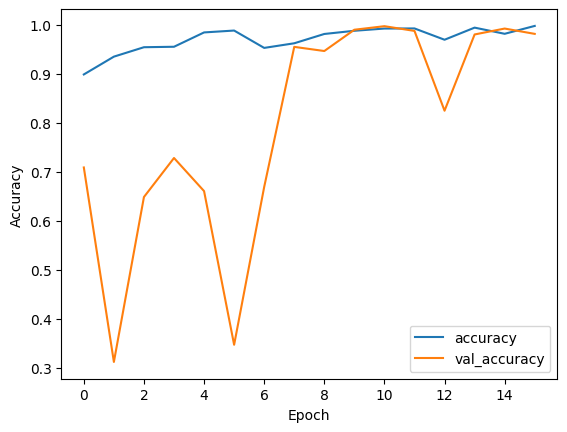

In [7]:
# Save the trained model
model_path = '/content/drive/MyDrive/CNN_MODEL1/xception/model_11/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
model.save(os.path.join(model_path, 'model_multiclass.keras'))

# Save the training history
history_path = '/content/drive/MyDrive/CNN_MODEL1/xception/history_11/'
if not os.path.exists(history_path):
    os.makedirs(history_path)
training_metrics = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
}
with open(os.path.join(history_path, 'training_history_multiclass_11.pkl'), 'wb') as file:
    pickle.dump(training_metrics, file)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [8]:
# Prediction of the result

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image

class ImageClassifier:
    def __init__(self, model_path):
        self.model = load_model(model_path)

    def preprocess_image(self, img_path):
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

    def classify_image(self, img_path):
        img_array = self.preprocess_image(img_path)
        predictions = self.model.predict(img_array)
        return predictions

    def plot_images_with_labels(self, image_folder):
        images = os.listdir(image_folder)
        num_images = len(images)

        num_cols = 2
        num_rows = num_images

        fig_height = num_rows * 4

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))

        for i, img_name in enumerate(images):
            img_path = os.path.join(image_folder, img_name)
            original_image = Image.open(img_path)  # Open image using PIL
            original_image = original_image.resize((128, 128))  # Resize image
            img_array = image.img_to_array(original_image)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            predictions = self.model.predict(img_array)

            row_index = i
            col_index = 0

            axes[row_index, col_index].imshow(original_image)
            axes[row_index, col_index].axis('off')

            predicted_label = np.argmax(predictions[0])
            predicted_probability = predictions[0][predicted_label]
            tumor_types = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
            label_name = tumor_types[predicted_label]

            if label_name == 'glioma_tumor' or label_name == 'meningioma_tumor' or label_name == 'pituitary_tumor':
                label_assigned = 'Tumor Present'
            else:
                label_assigned = 'Tumor Not found'

            table_data = [['Prediction:', label_assigned], ['Probability:', f'{predicted_probability:.2f}']]
            axes[row_index, col_index + 1].axis('off')
            axes[row_index, col_index + 1].table(cellText=table_data, loc='center', colWidths=[0.5, 0.5])

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/CNN_MODEL1/xception/model_11/model_multiclass.keras'

    # Initialize the classifier with the model
    classifier = ImageClassifier(model_path)

    # Set the image folder
    image_folder = "/content/drive/MyDrive/CNN_MODEL1/Testing_9"

    # Plot images with labels
    classifier.plot_images_with_labels(image_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 20ms/step
